In [3]:
import os
import numpy as np
import pandas as pd
import torch.optim as optim
import torch

In [ ]:
data_dir = "C:\\Users\\arjav\\Downloads\\Project\\AIH\\Combined_data"  
img_dir = os.path.join(data_dir, "img")
ann_dir = os.path.join(data_dir, "ann")
masks_human_dir = os.path.join(data_dir, "masks_human")
masks_machine_dir = os.path.join(data_dir, "masks_machine")
metadata_path = os.path.join(data_dir, 'Metadata.xlsx')

metadata_df = pd.read_excel(metadata_path)

def get_file_paths(directory):
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return file_paths

img_paths = get_file_paths(img_dir)
ann_paths = get_file_paths(ann_dir)
masks_human_paths = get_file_paths(masks_human_dir)
masks_machine_paths = get_file_paths(masks_machine_dir)

data = {
    'Image': img_paths,
    'Annotation': ann_paths,
    'Mask_Human': masks_human_paths,
    'Mask_Machine': masks_machine_paths
}

data_df = pd.DataFrame(data)

data_df['Filename'] = data_df['Image'].apply(lambda x: os.path.basename(x))
merged_df = pd.merge(data_df, metadata_df, left_on='Filename', right_on='Filename', how='inner')

print(merged_df.head())


                                               Image  \
0  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
1  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
2  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
3  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
4  C:\Users\arjav\Downloads\Project\AIH\Combined_...   

                                          Annotation  \
0  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
1  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
2  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
3  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
4  C:\Users\arjav\Downloads\Project\AIH\Combined_...   

                                          Mask_Human  \
0  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
1  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
2  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
3  C:\Users\arjav\Downloads\Project\AIH\Combined_...   
4  C:\Users\arjav\Downloads\Project\AIH\Combin

In [5]:
data = merged_df.drop(merged_df.columns[[i for i in range(1,12)]], axis=1)

In [6]:
data['binary_label'] = data['Label'].apply(lambda x: 0.0 if x == 'Normal' else 1.0)

dataset = data.drop(columns=['Label'])

from sklearn.model_selection import train_test_split

training_data , testing_data = train_test_split(dataset,test_size=0.2, random_state=42)


# NETWORK

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the model class
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()a
        self.conv1 = nn.Conv2d(1, 4, kernel_size=2, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(8, 24, kernel_size=2, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(2/, 32, kernel_size=2, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(32 * 32 * 32, 32)
        self.fc2 = nn.Linear(32, 1)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return torch.sigmoid(x)  # Sigmoid for binary classification


In [8]:
# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToTensor(),
])

images = []
labels = []
for idx in range(len(training_data)):
    img_path = training_data.iloc[idx, 0]
    label = training_data.iloc[idx, 1]
    
    
    image = Image.open(img_path).convert('L') 
    image = transform(image)
    
    images.append(image)
    labels.append(label)

val_images = []
val_labels = []
for idx in range(len(testing_data)):
    img_path = training_data.iloc[idx, 0]
    label = training_data.iloc[idx, 1]
    
    
    image = Image.open(img_path).convert('L') 
    image = transform(image)
    
    val_images.append(image)
    val_labels.append(label)




images = torch.stack(images)
labels = torch.tensor(labels)

val_images = torch.stack(val_images)
val_labels = torch.tensor(val_labels)

dataset = torch.utils.data.TensorDataset(images, labels)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

validation_set = torch.utils.data.TensorDataset(val_images, val_labels)

val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

In [10]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0, path='best_model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), self.path)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(val_loader)

def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, patience, n_epochs, device):
    early_stopping = EarlyStopping(patience=patience, path='best_model.pth')
    
    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # Check early stopping condition
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)



train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, patience=5, n_epochs=50, device=device)

model.load_state_dict(torch.load('best_model.pth'))

Epoch 1, Train Loss: 0.6620, Validation Loss: 0.6341
Epoch 2, Train Loss: 0.6520, Validation Loss: 0.6340
Epoch 3, Train Loss: 0.6501, Validation Loss: 0.6355
Epoch 4, Train Loss: 0.5659, Validation Loss: 0.4133
Epoch 5, Train Loss: 0.4185, Validation Loss: 0.3899
Epoch 6, Train Loss: 0.3765, Validation Loss: 0.3753
Epoch 7, Train Loss: 0.3547, Validation Loss: 0.3107
Epoch 8, Train Loss: 0.3083, Validation Loss: 0.2810
Epoch 9, Train Loss: 0.2946, Validation Loss: 0.2256
Epoch 10, Train Loss: 0.2952, Validation Loss: 0.3283
Epoch 11, Train Loss: 0.2821, Validation Loss: 0.2519
Epoch 12, Train Loss: 0.2565, Validation Loss: 0.2106
Epoch 13, Train Loss: 0.2513, Validation Loss: 0.2919
Epoch 14, Train Loss: 0.2444, Validation Loss: 0.1793
Epoch 15, Train Loss: 0.2573, Validation Loss: 0.2187
Epoch 16, Train Loss: 0.2154, Validation Loss: 0.1476
Epoch 17, Train Loss: 0.2008, Validation Loss: 0.1658
Epoch 18, Train Loss: 0.2021, Validation Loss: 0.1438
Epoch 19, Train Loss: 0.2020, Validat

C:\Users\arjav\AppData\Local\Temp\ipykernel_29320\766551239.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

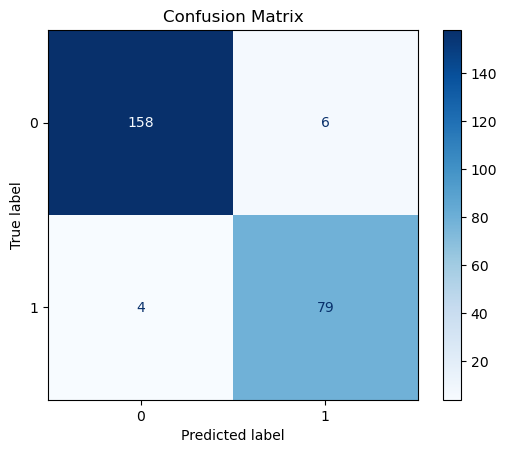

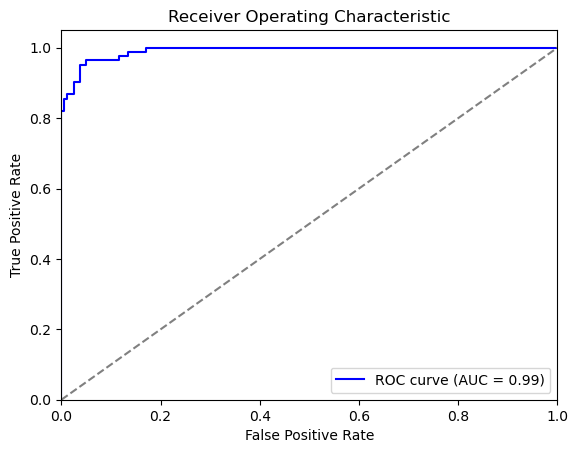

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()  
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():  
        for inputs, labels in test_loader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)  
            
        
            all_probs.append(outputs.cpu().numpy()) 
            preds = (outputs > 0.5).int()  
            all_preds.append(preds.cpu().numpy())  
            all_labels.append(labels.cpu().numpy())  
    
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    
    return all_labels, all_preds, all_probs

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(labels, probs):
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = roc_auc_score(labels, probs)
    
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


from torch.utils.data import DataLoader, TensorDataset

validation_set = TensorDataset(val_images, val_labels)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=False) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels, preds, probs = evaluate_model(model, validation_loader, device)

if labels is not None and preds is not None:
    plot_confusion_matrix(labels, preds)

if labels is not None and probs is not None:
    plot_roc_curve(labels, probs)

In [12]:
import numpy as np
from sklearn.metrics import classification_report

# Define class names
target_names = ['Normal', 'Covid']  # Adjust this based on your classes

# Generate the classification report
report = classification_report(labels, preds, target_names=target_names)

# Print the report
print(report)


              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97       164
       Covid       0.93      0.95      0.94        83

    accuracy                           0.96       247
   macro avg       0.95      0.96      0.95       247
weighted avg       0.96      0.96      0.96       247

